In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import convex_hull_image
import tifffile

In [2]:
import napari

In [3]:
viewer = napari.Viewer()
viewer.open_sample('napari', 'cells3d')
membrane_layer = viewer.layers[0]
nuclei_layer = viewer.layers[1]

In [4]:
# numpy label data
import tifffile
label_data = tifffile.imread('criss-cross-labels.tif')
viewer.add_labels(label_data)
label_layer = viewer.layers[-1]
labels = label_layer.data

In [5]:
from skimage.morphology import convex_hull_image

In [6]:
chull = convex_hull_image(labels)

In [6]:
# The scikit-image convex hull implementation looks good
# but is slow to compute (~10 seconds just for this tiny 3D image)
# ...but it's also using the C++ qhull algorithm under the hood, so we may not be able to speed it up
%timeit convex_hull_image(labels)
# 9.15 s ± 160 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

9.15 s ± 160 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


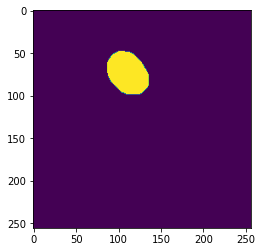

In [7]:
plt.imshow(chull[30,...])

In [8]:
viewer.add_labels(chull)

<Labels layer 'chull' at 0x2961fe5b0>

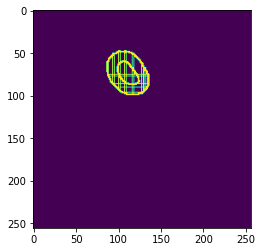

In [27]:
from skimage import filters

edges = filters.sobel(label_data)  # canny and roberts are 2D only, sobel can handle 3d case
edges = edges > 0

plt.imshow(edges[30])

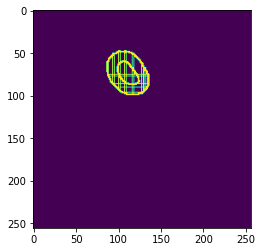

In [23]:
plt.imshow(edges[30] > 0)

In [28]:
chull = convex_hull_image(edges)

In [ ]:
plt.imshow(chull[30,...])

In [29]:
# The scikit-image convex hull implementation looks good
# but is slow to compute (~10 seconds just for this tiny 3D image)
# ...but it's also using the C++ qhull algorithm under the hood, so we may not be able to speed it up
%timeit convex_hull_image(edges)
# 20.8 s ± 1.34 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

20.8 s ± 1.34 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


How is it somehow EVEN SLOWER to run than before?

...This approach is not going to be very practical for big datasets :(

### Qhull accelerated algorithm
* 
* PyHull wrapper documentation: https://pythonhosted.org/pyhull/
* Qhull is available from conda-forge: https://anaconda.org/conda-forge/qhull
* Here's an explanation of how the quickhull algorithm works: https://www.youtube.com/watch?v=2EKIZrimeuk

In [11]:
import qhull

ModuleNotFoundError: No module named 'qhull'

In [14]:
!pip install pyhull

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.8/318.8 KB 3.6 MB/s eta 0:00:00m eta 0:00:010:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyhull: filename=pyhull-2015.2.1-cp39-cp39-macosx_11_0_arm64.whl size=181110 sha256=310d66c1858778a63c93c18bdd08b25a726947f6e267e3ec91d1cab69b32bd79
  Stored in directory: /Users/genevieb/Library/Caches/pip/wheels/24/4f/ce/68f0ec603d3be7e93d2fd7ca95a77d8191505e1055ae94406d
Successfully built pyhull


In [20]:
import pyhull
from pyhull.convex_hull import ConvexHull


In [22]:
pts = np.argwhere(labels)
qhull = ConvexHull(pts)
qhull

In [42]:
qhull.points

array([[ 19,  59, 108],
       [ 19,  60, 108],
       [ 19,  61, 108],
       ...,
       [ 49,  71, 108],
       [ 49,  72, 108],
       [ 49,  73, 108]])

In [44]:
qhull.simplices

[3-simplex in 3D space
 Vertices:
 	(22, 62, 94)
 	(24, 57, 94)
 	(28, 64, 87),
 3-simplex in 3D space
 Vertices:
 	(24, 53, 101)
 	(22, 56, 101)
 	(19, 59, 108),
 3-simplex in 3D space
 Vertices:
 	(22, 56, 101)
 	(24, 53, 101)
 	(24, 57, 94),
 3-simplex in 3D space
 Vertices:
 	(35, 97, 113)
 	(30, 98, 110)
 	(30, 96, 105),
 3-simplex in 3D space
 Vertices:
 	(21, 66, 94)
 	(22, 62, 94)
 	(28, 64, 87),
 3-simplex in 3D space
 Vertices:
 	(20, 72, 101)
 	(21, 71, 94)
 	(21, 84, 101),
 3-simplex in 3D space
 Vertices:
 	(43, 80, 101)
 	(46, 82, 108)
 	(38, 87, 100),
 3-simplex in 3D space
 Vertices:
 	(22, 59, 117)
 	(23, 56, 112)
 	(19, 59, 108),
 3-simplex in 3D space
 Vertices:
 	(41, 52, 117)
 	(41, 48, 108)
 	(39, 51, 117),
 3-simplex in 3D space
 Vertices:
 	(46, 53, 108)
 	(41, 50, 100)
 	(41, 48, 108),
 3-simplex in 3D space
 Vertices:
 	(41, 60, 124)
 	(41, 52, 117)
 	(39, 51, 117),
 3-simplex in 3D space
 Vertices:
 	(41, 52, 117)
 	(41, 60, 124)
 	(44, 55, 117),
 3-simplex i

In [54]:
qhull.vertices

[[314, 1604, 2894],
 [1597, 299, 0],
 [299, 1597, 1604],
 [6940, 5061, 5017],
 [143, 314, 2894],
 [55, 163, 241],
 [9914, 10335, 7832],
 [307, 538, 0],
 [8496, 8449, 7918],
 [10244, 8451, 8449],
 [8715, 8496, 7918],
 [8496, 8715, 9981],
 [7922, 8451, 9578],
 [8451, 7922, 6960],
 [7297, 8451, 6960],
 [8451, 7297, 8449],
 [121, 490, 298],
 [10124, 9756, 10335],
 [10335, 9756, 7832],
 [9756, 8151, 7832],
 [8151, 4990, 7832],
 [4990, 6940, 5017],
 [4990, 8151, 6940],
 [7295, 5061, 6940],
 [6879, 7593, 7182],
 [7593, 6879, 6919],
 [9914, 10593, 10335],
 [3616, 2844, 3583],
 [3616, 3784, 1604],
 [1604, 3784, 2894],
 [3784, 3616, 6960],
 [143, 23, 314],
 [314, 23, 1604],
 [10593, 9132, 9853],
 [9132, 10593, 9914],
 [9132, 9914, 7832],
 [8449, 7614, 7918],
 [7297, 7614, 8449],
 [8715, 10250, 9981],
 [10250, 10244, 9981],
 [10244, 10250, 10664],
 [10250, 10661, 10664],
 [3615, 7614, 6222],
 [7614, 3615, 7918],
 [307, 3615, 538],
 [7922, 6640, 6960],
 [6640, 3784, 6960],
 [273, 121, 241],
 [490,

In [55]:
print(len(qhull.points))
print(len(qhull.simplices))
print(len(qhull.vertices))

10679
294
294


In [53]:
dir(qhull)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'dim',
 'points',
 'simplices',
 'vertices']

In [48]:
dir(face)


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_coords',
 'bary_coords',
 'coords',
 'in_simplex',
 'origin',
 'simplex_dim',
 'space_dim',
 'volume']

In [51]:
face.coords

array([[ 29,  52, 117],
       [ 30,  50, 115],
       [ 22,  59, 117]])

In [52]:
face.volume

AttributeError: 'Simplex' object has no attribute 'T'

In [45]:
for face in qhull.simplices:
    print(face)

3-simplex in 3D space
Vertices:
	(22, 62, 94)
	(24, 57, 94)
	(28, 64, 87)
3-simplex in 3D space
Vertices:
	(24, 53, 101)
	(22, 56, 101)
	(19, 59, 108)
3-simplex in 3D space
Vertices:
	(22, 56, 101)
	(24, 53, 101)
	(24, 57, 94)
3-simplex in 3D space
Vertices:
	(35, 97, 113)
	(30, 98, 110)
	(30, 96, 105)
3-simplex in 3D space
Vertices:
	(21, 66, 94)
	(22, 62, 94)
	(28, 64, 87)
3-simplex in 3D space
Vertices:
	(20, 72, 101)
	(21, 71, 94)
	(21, 84, 101)
3-simplex in 3D space
Vertices:
	(43, 80, 101)
	(46, 82, 108)
	(38, 87, 100)
3-simplex in 3D space
Vertices:
	(22, 59, 117)
	(23, 56, 112)
	(19, 59, 108)
3-simplex in 3D space
Vertices:
	(41, 52, 117)
	(41, 48, 108)
	(39, 51, 117)
3-simplex in 3D space
Vertices:
	(46, 53, 108)
	(41, 50, 100)
	(41, 48, 108)
3-simplex in 3D space
Vertices:
	(41, 60, 124)
	(41, 52, 117)
	(39, 51, 117)
3-simplex in 3D space
Vertices:
	(41, 52, 117)
	(41, 60, 124)
	(44, 55, 117)
3-simplex in 3D space
Vertices:
	(39, 53, 94)
	(41, 50, 100)
	(42, 56, 94)
3-simplex

In [38]:
qhull.simplices

[3-simplex in 3D space
 Vertices:
 	(22, 62, 94)
 	(24, 57, 94)
 	(28, 64, 87),
 3-simplex in 3D space
 Vertices:
 	(24, 53, 101)
 	(22, 56, 101)
 	(19, 59, 108),
 3-simplex in 3D space
 Vertices:
 	(22, 56, 101)
 	(24, 53, 101)
 	(24, 57, 94),
 3-simplex in 3D space
 Vertices:
 	(35, 97, 113)
 	(30, 98, 110)
 	(30, 96, 105),
 3-simplex in 3D space
 Vertices:
 	(21, 66, 94)
 	(22, 62, 94)
 	(28, 64, 87),
 3-simplex in 3D space
 Vertices:
 	(20, 72, 101)
 	(21, 71, 94)
 	(21, 84, 101),
 3-simplex in 3D space
 Vertices:
 	(43, 80, 101)
 	(46, 82, 108)
 	(38, 87, 100),
 3-simplex in 3D space
 Vertices:
 	(22, 59, 117)
 	(23, 56, 112)
 	(19, 59, 108),
 3-simplex in 3D space
 Vertices:
 	(41, 52, 117)
 	(41, 48, 108)
 	(39, 51, 117),
 3-simplex in 3D space
 Vertices:
 	(46, 53, 108)
 	(41, 50, 100)
 	(41, 48, 108),
 3-simplex in 3D space
 Vertices:
 	(41, 60, 124)
 	(41, 52, 117)
 	(39, 51, 117),
 3-simplex in 3D space
 Vertices:
 	(41, 52, 117)
 	(41, 60, 124)
 	(44, 55, 117),
 3-simplex i

In [37]:
np.array(qhull.vertices).shape


(294, 3)

The data for a surface layer is defined by a 3-tuple of its:

1. vertices, 
2. faces, and 
3. vertex values. 

* The vertices are an NxD array of N vertices in D coordinates.

* The faces are an Mx3 integer array of the indices of the triangles making up the faces of the surface.

* The vertex values are a length N list of values to associate with each vertex to use alongside a colormap.

This 3-tuple is accessible through the layer.data property.


In [ ]:
vertices = np.array(qhull.vertices)
values = np.ones(len(vertices))
surface = (qhull.vertices, faces, values)
viewer.add_surface(surface)

In [33]:
vertices = np.array([[0, 0], [0, 20], [10, 0], [10, 10]])
faces = np.array([[0, 1, 2], [1, 2, 3]])
values = np.ones(len(vertices))#np.linspace(0, 1, len(vertices))
surface = (vertices, faces, values)

napari.view_surface(surface)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 5.0, 10.0), zoom=16.435, angles=(0.0, 0.0, 90.0), perspective=0, interactive=True), cursor=Cursor(position=(1, 1), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 11.0, 1.0), (0.0, 21.0, 1.0)), current_step=(5, 10), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Surface layer 'surface' at 0x28c7bd6a0>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10, unit=None), text_overlay=TextOverlay(visible=False, color=(0.5, 0.5, 0.5, 1.0), font_size=10, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_box=InteractionBox(points=None, show=False, show_handle=False, show_vertices=False, selection_box_drag=None, selection_box_final=None, tra

In [30]:
print("vertices.shape", vertices.shape)
print("faces.shape", faces.shape)
print("values.shape", values.shape)

vertices.shape (4, 2)
faces.shape (2, 3)
values.shape (4,)


In [31]:
len(vertices)

4

In [74]:
verts

array([[ 0,  0],
       [ 0, 20],
       [10,  0],
       [10, 10],
       [ 5,  5]])

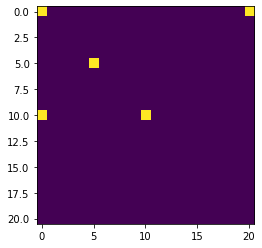

In [69]:
verts = np.array([[0, 0], [0, 20], [10, 0], [10, 10], [5, 5]])
img = np.zeros((21,21))
img[0, 0] = 1
img[0, 20] = 1
img[10, 0] = 1
img[10, 10] = 1
img[5, 5] = 1
plt.imshow(img)

In [70]:
test_pts = np.argwhere(img)
test_qhull = ConvexHull(test_pts)
test_qhull

In [71]:
print(len(test_qhull.points))
print(len(test_qhull.vertices))
print(len(test_qhull.simplices))

5
4
4


In [72]:
print(test_qhull.points)

[[ 0  0]
 [ 0 20]
 [ 5  5]
 [10  0]
 [10 10]]


In [75]:
print(test_qhull.vertices)

[[0, 3], [1, 0], [3, 4], [4, 1]]


In [68]:
real_vertices = np.array([[test_qhull.points[pt1], test_qhull.points[pt2]] for pt1, pt2 in test_qhull.vertices])
print(real_vertices)

[[[ 0  0]
  [10  0]]

 [[ 0 20]
  [ 0  0]]

 [[10  0]
  [10 10]]

 [[10 10]
  [ 0 20]]]


In [63]:
print(test_qhull.simplices)

[2-simplex in 2D space
Vertices:
	(0, 0)
	(10, 0), 2-simplex in 2D space
Vertices:
	(0, 20)
	(0, 0), 2-simplex in 2D space
Vertices:
	(10, 0)
	(10, 10), 2-simplex in 2D space
Vertices:
	(10, 10)
	(0, 20)]


## Test

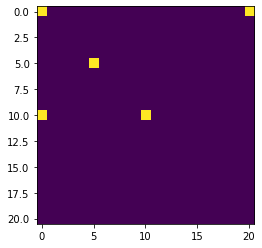

In [78]:
import numpy as np
import matplotlib.pyplot as plt

pts = np.array([[0, 0], [0, 20], [10, 0], [10, 10], [5, 5]])
img = np.zeros((21, 21))
img[0, 0] = 1
img[0, 20] = 1
img[10, 0] = 1
img[10, 10] = 1
img[5, 5] = 1

plt.imshow(img)

In [81]:
from pyhull.convex_hull import ConvexHull

hull = ConvexHull(pts)
print("vertices")
print(hull.vertices)
print("points")
print(hull.points)
print("simplices")
print(hull.simplices)

vertices
[[0, 2], [1, 0], [2, 3], [3, 1]]
points
[[ 0  0]
 [ 0 20]
 [10  0]
 [10 10]
 [ 5  5]]
simplices
[2-simplex in 2D space
Vertices:
	(0, 0)
	(10, 0), 2-simplex in 2D space
Vertices:
	(0, 20)
	(0, 0), 2-simplex in 2D space
Vertices:
	(10, 0)
	(10, 10), 2-simplex in 2D space
Vertices:
	(10, 10)
	(0, 20)]


In [79]:
from pyhull.delaunay import DelaunayTri

tri = DelaunayTri(pts)
print("Vertices")
print(tri.vertices)
print("Points")
print(tri.points)


Vertices
[[2, 4, 0], [3, 4, 2], [4, 1, 0], [4, 3, 1]]
Points
[[ 0  0]
 [ 0 20]
 [10  0]
 [10 10]
 [ 5  5]]


In [80]:
dir(tri)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'dim',
 'points',
 'simplices',
 'vertices']